# Ising Model GAN 

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../..")
from Plots.style import *
from Model.input_pipeline import dataset_tfrecord_pipeline
import time
from IPython import display
from pathlib import Path
from datetime import datetime
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers

data_path = Path("../../GetData/Python/Data")

2024-04-15 06:54:20.909538: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Plotting

In [2]:
def sample_data_plots(generator, batch_size, outdir):
  sample_data = []
  reals = []
  for image, temp in test_dataset:
    image = plus_encode_data(image)
    random_vector_for_generation = tf.random.normal([batch_size, 1, 1, noise_dim])
    generated = generator(random_vector_for_generation)
    sample_data.append(np.random.binomial(1, generated))
    reals.append(image)
  temp = temp.numpy()[0]

  generated_spins = np.concatenate(sample_data)
  real_spins = np.concatenate(reals)
  generated_spins =  2 * (generated_spins > 0) - 1
  real_spins =  2 * real_spins - 1
  generated_spins = random_swap(generated_spins)
  real_spins = random_swap(real_spins)

  df_test = process_data(real_spins)
  df_test['Algorithm'] = 'Wolff testset'

  df_sample = process_data(generated_spins)
  df_sample['Algorithm'] = 'GAN Generator'

  assert len(df_sample) == len(df_test)
  df = pd.concat([df_test, df_sample])
    
  sns.displot(df, x = 'Magnetization', kind ='kde', hue='Algorithm')
  plt.savefig(outdir / f"mag_{temp}.svg")
  sns.displot(df, x = 'Energy', kind ='kde', hue='Algorithm')
  plt.savefig(outdir / f"energy_{temp}.svg")

def process_data(spin_image):
  df = pd.DataFrame({'image': list(spin_image)})
  df['Magnetization'] = df['image'].apply(calcMag)
  df['Energy'] = df['image'].apply(calcEnergy)
  df.drop(columns='image', inplace=True)
  return df
    
def random_swap(data):
    data = tf.reshape(data, shape = (data.shape[0], -1))
    swap_mask = 2 * (np.random.random(size = (data.shape[0], 1)) > 0.5) - 1
    data = tf.multiply(data, swap_mask)
    data = tf.reshape(data, shape = (-1, 32, 32, 1))
    return data
    
def calcEnergy(mat):
    '''Energy of a given configuration'''
    matrix_sum = get_neighbour_sum_matrix(mat)
    return - np.sum(np.multiply(matrix_sum, mat))

def calcMag(mat):
    '''Magnetization of a given configuration'''
    mag = np.sum(mat)
    return mag
    
def get_neighbour_sum_matrix(mat):
    """Matrix of the sum of spin values for all neighboring cells."""
    # Define shifts for different directions
    shifts = [
        (1, 1),  # Right
        (-1, 1),  # Left
        (-1, 0),  # Up
        (1, 0),  # Down
        (-1, 1),  # Up-Right
        (1, 1),  # Down-Right
        (-1, -1),  # Up-Left
        (1, -1),  # Down-Left
    ]

    # Initialize an empty matrix for the sum of neighboring cells
    neighbor_sum = np.zeros_like(mat)

    # Iterate through each shift and accumulate the values in neighbor_sum
    for shift in shifts:
        shifted_mat = np.roll(mat, shift=shift, axis=(0, 1))
        neighbor_sum += shifted_mat

    return neighbor_sum

In [3]:
def generate_and_save_images(model, epoch, test_input, outdir):
    predictions = tf.round(model(test_input, training=False))
    
    plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0])
      plt.axis('off')
        
    plt.savefig(outdir / 'image_at_epoch_{:04d}.svg'.format(epoch))
    plt.show()
    
    
def plot_cost_function(outdir):
    fig, ax1 = plt.subplots()
    ax1.plot(np.asarray(disc_loss_log), color='tab:red')
    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Discriminator Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    
    ax2 = ax1.twinx()
    ax2.plot(np.asarray(gen_loss_log), color='tab:blue')
    ax2.set_ylabel('Generator Loss', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    plt.savefig(outdir / 'cost_function.svg')
    plt.show()

# Data Pipeline

In [4]:
class DataIterator:
    def __init__(self, datasets, temps):
        self.datasets = datasets
        self.temps = temps
    def __iter__(self):
        self.data_iterators = [iter(data) for data in self.datasets]
        return self
    
    def __next__(self):
        data_list = []
        temp_list = []
        for index, data_iterator in enumerate(self.data_iterators):
            data = next(data_iterator)
            data_list.append(data)
            temp = self.temps[index] * np.ones((data.shape[0], 1))
            temp_list.append(temp)
        temps = tf.concat(temp_list, axis=0)
        data = tf.concat(data_list, axis=0)
        return data, temps
        
def make_dataset(data_dir, temps, batch_size=100, flatten=False):
    if isinstance(data_dir, str):
        data_dir = Path(data_dir)
    
    assert batch_size % len(temps) == 0, "Batch size must be divisible by the number of temperatures"

    trainset = []
    testset = []
    for temp in temps:
        dataset = dataset_tfrecord_pipeline(data_dir / f"Data{temp:.1f}.tfrecord", flatten=flatten, batch_size=batch_size // len(temps))
        trainset.append(dataset)
        dataset = dataset_tfrecord_pipeline(data_dir / f"TestData{temp:.1f}.tfrecord", flatten=flatten, batch_size=batch_size // len(temps))
        testset.append(dataset)
    gen_test = DataIterator(testset, temps)
    test_dataset = tf.data.Dataset.from_generator(lambda: gen_test, output_signature = (tf.TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32), tf.TensorSpec(shape=(None, 1), dtype=tf.float32)))
    gen_train = DataIterator(trainset, temps)
    train_dataset = tf.data.Dataset.from_generator(lambda: gen_train, output_signature = (tf.TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32), tf.TensorSpec(shape=(None, 1), dtype=tf.float32)))
    return train_dataset, test_dataset

def plus_encode_data(data):
    data = tf.reshape(data, shape=(data.shape[0], -1))
    mean_data = tf.reduce_mean(data, axis=1, keepdims=True)
    need_change = tf.cast(mean_data < 0.5, data.dtype)
    data = data * (1 - 2 * need_change) + need_change
    data = tf.reshape(data, shape=(-1, 32, 32, 1))
    return data   

# GAN

## Architecture

In [5]:
def make_generator_model(nc = 1, ngf = 64):
    model = tf.keras.Sequential([
        # input is Z, going into a convolution
        tf.keras.layers.Conv2DTranspose(ngf * 8, (4, 4), strides=(1, 1), padding='valid', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        # state size. (ngf*8) x 4 x 4
        tf.keras.layers.Conv2DTranspose(ngf * 4, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        # state size. (ngf*4) x 8 x 8
        tf.keras.layers.Conv2DTranspose(ngf * 2, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        # state size. (ngf*2) x 16 x 16
        tf.keras.layers.Conv2DTranspose(nc, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.Activation('sigmoid')
        # state size. (nc) x 32 x 32
    ])
    return model

def make_discriminator_model(ndf = 64):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(ndf, (4, 4), strides=(2, 2), padding='same', use_bias=False, 
                               kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Conv2D(ndf * 2, (4, 4), strides=(2, 2), padding='same', use_bias=False, 
                               kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Conv2D(ndf * 4, (4, 4), strides=(2, 2), padding='same', use_bias=False, 
                               kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Conv2D(1, (4, 4), strides=(1, 1), padding='valid', use_bias=False, 
                               kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    ])
    return model
    
def build_wdiscriminator(ndf=64):
    model = tf.keras.Sequential([

        # state size. (ndf) x 32 x 32
        tf.keras.layers.Conv2D(ndf, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.2),

        # state size. (ndf*2) x 16 x 16
        tf.keras.layers.Conv2D(ndf * 2, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.2),

        # state size. (ndf*4) x 8 x 8
        tf.keras.layers.Conv2D(ndf * 4, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.2),

        # state size. (ndf*8) x 4 x 4
        tf.keras.layers.Conv2D(1, (4, 4), strides=(1, 1), padding='valid', use_bias=False)
    ])
    return model
    
def initialize_weights(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Conv2DTranspose):
            layer.weights[0] = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)(shape=layer.weights[0].shape)
        elif isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.weights[0] = tf.keras.initializers.RandomNormal(mean=1., stddev=0.02)(shape=layer.weights[0].shape)
            layer.weights[1] = tf.keras.initializers.Zeros()(shape=layer.weights[1].shape)


## Training loop

In [6]:
def train_step(batch, gen_loss_log, disc_loss_log, batch_size, noise_dim, generator, discriminator, generator_optimizer, discriminator_optimizer, regression_model):
      noise = tf.random.normal([batch_size, 1, 1, noise_dim])
      images, temps = batch
      images = plus_encode_data(images)
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generator's images
        generated_images = generator(noise, training=True)
        
          
        # Estimated temperature by regression network
        estimated_temps = regression_model(generated_images)

        # Discriminator part  
        real_logits = discriminator(images, training=True)
        generated_logits = discriminator(generated_images, training=True)

        # Cost Function
        gen_loss = generator_loss(generated_logits, estimated_temps, temps)
        gen_loss_log.append(gen_loss)
        disc_loss = discriminator_loss(real_logits, generated_logits)
        disc_loss_log.append(disc_loss)
        
        clip_value_min = -0.01
        clip_value_max = 0.01
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        # Clip the gradients
        gradients_of_generator = [tf.clip_by_value(grad, clip_value_min, clip_value_max) for grad in gradients_of_generator]
        gradients_of_discriminator = [tf.clip_by_value(grad, clip_value_min, clip_value_max) for grad in gradients_of_discriminator]
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs, batch_size, gen_loss_log, disc_loss_log, regression_model, outdir):  
    for epoch in range(epochs):
        start = time.time()
        for batch in tqdm(dataset): 
          train_step(
                 batch, 
                 gen_loss_log, 
                 disc_loss_log, 
                 batch_size, 
                 noise_dim, 
                 generator, 
                 discriminator, 
                 generator_optimizer, 
                 discriminator_optimizer,
                 regression_model
          )
        print (f"Time taken for epoch {epoch} is {time.time()- start} sec")
        display.clear_output(wait=True) 
        generate_and_save_images(
          generator,
          epoch + 1,
          random_vector_for_generation,
          outdir
        )

def generator_loss(generated_logits, estimated_temps, temps, lambda2 = 100):
    l1 = tf.losses.binary_crossentropy(tf.ones_like(generated_logits), generated_logits, from_logits = True)
    # Regression network
    l2 = tf.reduce_mean(tf.losses.mean_squared_error(estimated_temps, temps))
    return tf.reduce_mean(l1) + lambda2 * l2

def discriminator_loss(real_image, generated_image):
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_image), real_image, from_logits = True)
    generated_loss = tf.losses.binary_crossentropy(tf.zeros_like(generated_image), generated_image, from_logits = True)
    total_loss = tf.reduce_mean(real_loss) + tf.reduce_mean(generated_loss)
    #total_loss = tf.reduce_mean(tf.math.sigmoid(generated_image)) - tf.reduce_mean(tf.math.sigmoid(real_image))
    return total_loss

# Train

## Parameters

In [9]:
noise_dim = 100
num_examples_to_generate = 16
random_vector_for_generation = tf.random.normal([num_examples_to_generate, 1, 1, noise_dim])
beta1 = 0.5
lr = 1e-4
EPOCHS=20
temps = np.arange(2.3, 2.5, 0.1)
batch_size = 240

folder = "results/gan_v2.1"

# Get the current date and time
current_datetime = datetime.now()

# Format it to include date, hour, and minutes
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M")

results = Path("results/" + formatted_datetime)
results.mkdir()

regression_model = tf.keras.models.load_model("results/regression_model")

## Loop over temperatures

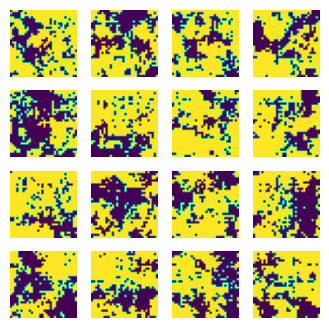

208it [00:56, 10.81it/s]

In [ ]:
for temp in temps:
    outdir = results / f"{temp:.1f}"
    outdir.mkdir(exist_ok = True)
    gen_loss_log=[]
    disc_loss_log=[]
    generator =  tf.keras.models.load_model(f"results/gan_v2.1/{temp:.1f}/generator")
    discriminator =  tf.keras.models.load_model(f"results/gan_v2.1/{temp:.1f}/discriminator")
    
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta1, beta_2=0.999)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta1, beta_2=0.999)
    
    discriminator.build(input_shape = (None, 32, 32, 1))
    generator.build(input_shape = (None, 1, 1, 100))
    
    initialize_weights(generator)
    initialize_weights(discriminator)
    
    train_dataset, test_dataset = make_dataset(data_path, [temp], batch_size=batch_size, flatten=False)
    train(train_dataset, EPOCHS, batch_size, gen_loss_log, disc_loss_log, regression_model, outdir)
    
    plot_cost_function(outdir)
    sample_data_plots(generator, batch_size, outdir)
    discriminator.save(outdir / "discriminator")
    generator.save(outdir / "generator")
